In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn
import sklearn
import sklearn.metrics as metrics
import statsmodels
import statsmodels.api as sm
import warnings

In [48]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

In [2]:
import sys
sys.path.append("/Users/missd/Desktop/6. Semester/6. Model Deployment Maintenance/MDM - Python Projekt/src/")
import mdm_python.data.db_wetter2 as db_wetter2
import mdm_python.data.db_entsoe as db_entsoe

In [3]:
weather_data = db_wetter2.extract_daily_average_weather()

In [4]:
energy_data = db_entsoe.extract_daily_energy()

In [5]:
weather_data = weather_data.drop(columns=["min_temp", "max_temp"])

## Check for Correlation to choose the important features

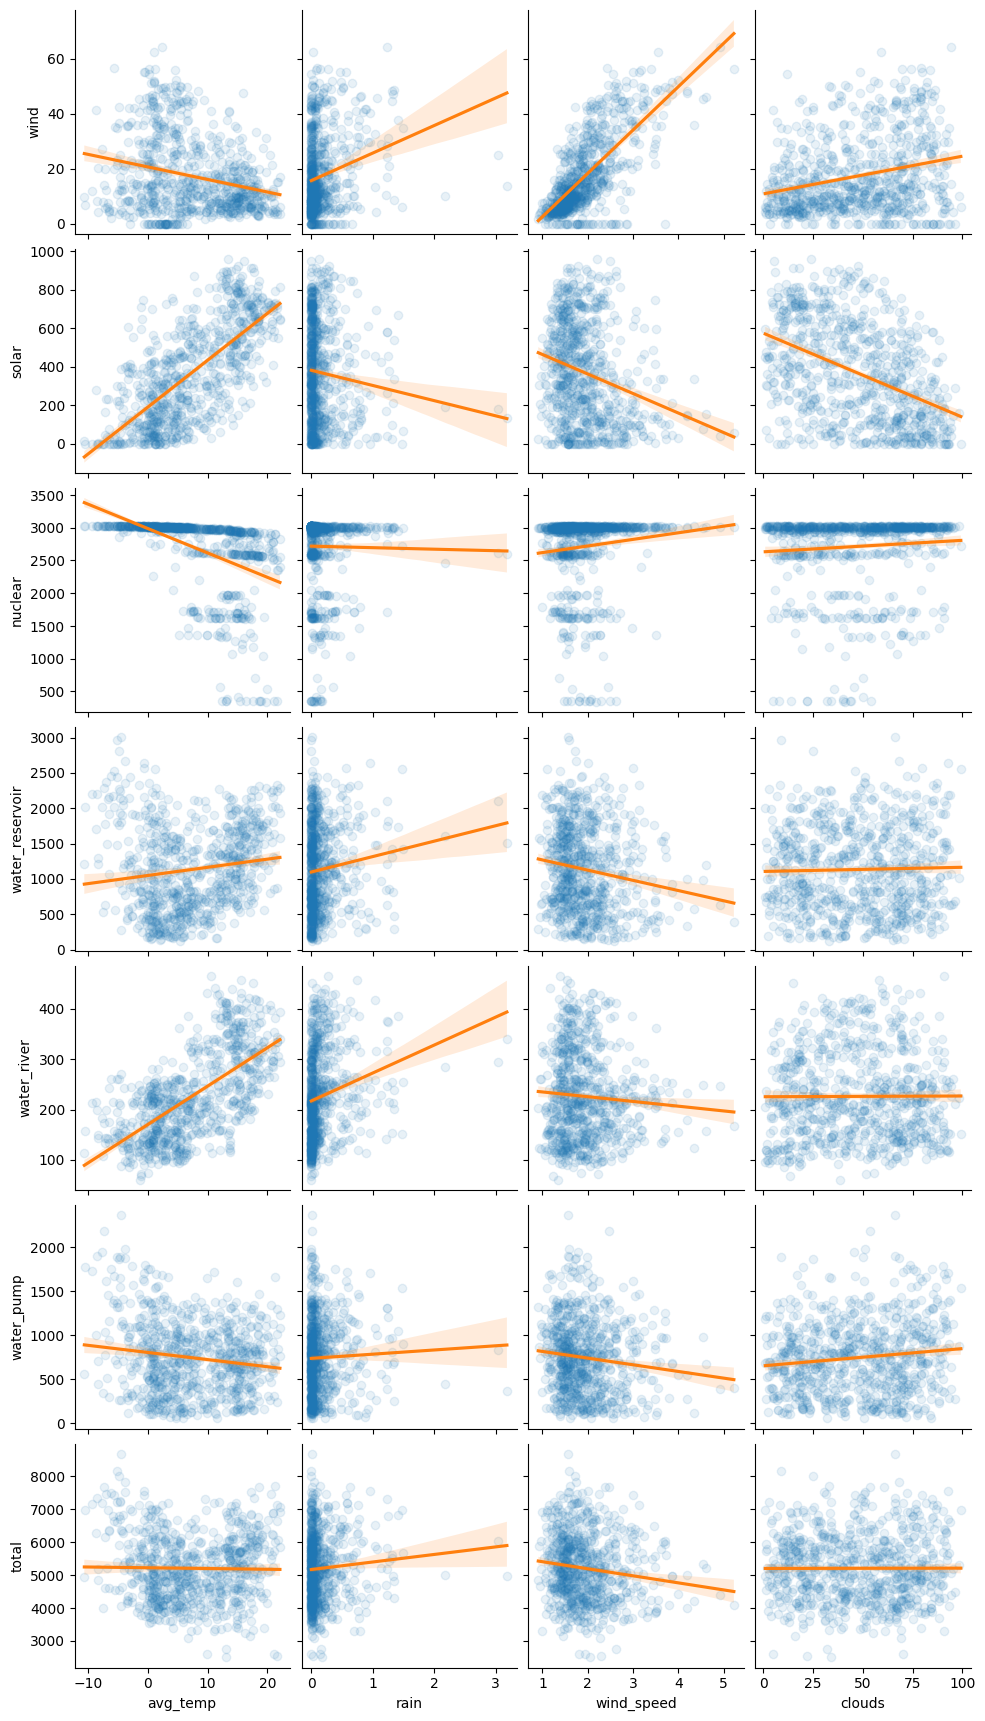

In [6]:
pairplot = seaborn.pairplot(
    data=pd.concat([weather_data, energy_data], axis="columns"),
    x_vars=weather_data.columns,
    y_vars=energy_data.columns,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.1,
        ),
        line_kws=dict(color='tab:orange'),
    )
)

plt.show()

In [7]:
correlation_matrix = pd.concat([weather_data, energy_data], axis="columns").corr()
correlation_matrix = correlation_matrix.loc[weather_data.columns, energy_data.columns]
high_correlation = correlation_matrix[((correlation_matrix > 0.5) | (correlation_matrix < -0.5))]
print(f'\nCorrelation higher than 0.3 or lower than -0.3:\n{high_correlation}')


Correlation higher than 0.3 or lower than -0.3:
                wind     solar  nuclear  water_reservoir  water_river  \
avg_temp         NaN  0.698923      NaN              NaN     0.644211   
rain             NaN       NaN      NaN              NaN          NaN   
wind_speed  0.715401       NaN      NaN              NaN          NaN   
clouds           NaN       NaN      NaN              NaN          NaN   

            water_pump  total  
avg_temp           NaN    NaN  
rain               NaN    NaN  
wind_speed         NaN    NaN  
clouds             NaN    NaN  


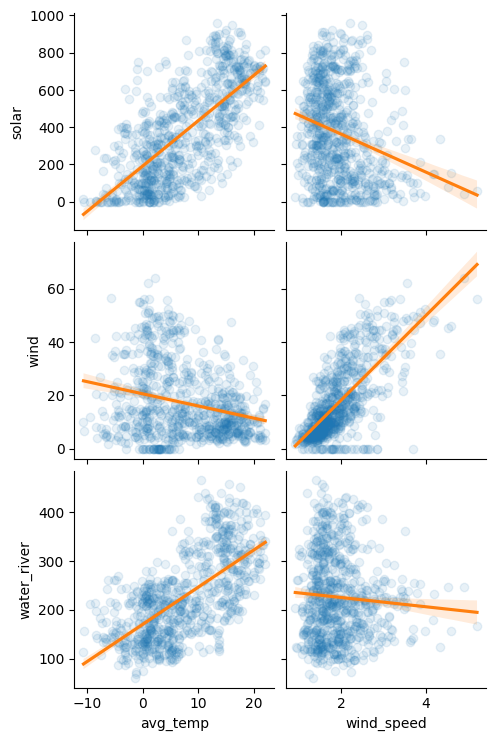

In [8]:
high_correlation_features = high_correlation.stack().index.tolist()
unique_weather_features = list(set([item[0] for item in high_correlation_features]))
unique_energy_features = list(set([item[1] for item in high_correlation_features]))

pairplot = seaborn.pairplot(
    data=pd.concat([weather_data[unique_weather_features], energy_data[unique_energy_features]], axis="columns"),
    x_vars=unique_weather_features,
    y_vars=unique_energy_features,
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(
            color="tab:blue",
            alpha=0.1,
        ),
        line_kws=dict(color='tab:orange'),
    )
)

plt.show()

## Check for missing Dates and Data and fix them

In [9]:
def show_missing_data(data):
    print(pd.date_range(start=data.index[0], end=data.index[-1]).difference(data.index))
    print(data.isnull().sum())

In [10]:
def fix_missing_data(data):
    """Create new DataFrame with the missing days in the index and NaN-Values
    Fill NaN-Values with the average between hre previous and the next value"""
    index_date = pd.date_range(start=data.index[0], end=data.index[-1], freq='D')
    new_data = data.reindex(index_date)
    new_data = new_data.interpolate(method='nearest')
    return new_data

In [11]:
show_missing_data(weather_data)
show_missing_data(energy_data)

DatetimeIndex(['2022-07-22 00:00:00+00:00', '2023-01-18 00:00:00+00:00',
               '2023-06-19 00:00:00+00:00', '2023-06-20 00:00:00+00:00',
               '2024-02-25 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)
avg_temp      0
rain          0
wind_speed    0
clouds        0
dtype: int64
DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='D')
wind               0
solar              0
nuclear            0
water_reservoir    0
water_river        0
water_pump         0
total              0
dtype: int64


In [12]:
weather_data = fix_missing_data(weather_data)
energy_data = fix_missing_data(energy_data)

## Create PandasSeries with the important features

In [13]:
weather_data_temp = weather_data.avg_temp
weather_data_wind = weather_data.wind_speed

energy_data_wind = energy_data.wind
energy_data_solar = energy_data.solar
energy_data_water_river = energy_data.water_river

# TimeSeries-Modelling Weather

## Analyzing and Preparing the Data

### Plot with original data

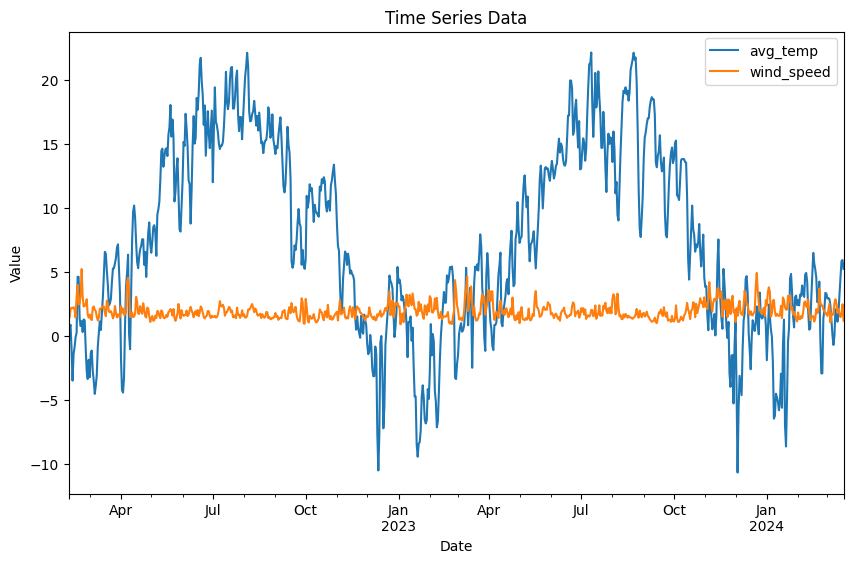

In [14]:
# Create a time series dataset
dates = weather_data.index

data_temp = weather_data.avg_temp
data_wind = weather_data.wind_speed

# Plot the time series
plt.figure(figsize=(10, 6))
data_temp.plot()
data_wind.plot()
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### Next Steps:
1.) Deseasonalize avg_temp.<br>
2.) Check for stationarity for wind_speed.<br>
3.) Check for stationarity for avg_temp.<br>
4.) Check for White Noise for wind_speed<br>
5.) Check for White Nose for avg_temp

In [15]:
def deseasonalize(data):
    return data.diff(12).dropna()

In [16]:
def check_for_stationarity(data):
    """
    Compute ADF-Value: If the value is very low (negative), it indicates, the data is Stationary
    Compute P-Value: If the value is between -0.05 and 0.05, it indicates, the data is Stationary
    """
    
    dftest = sm.tsa.stattools.adfuller(data, autolag="AIC")
    print(f'\nStationary-Test for {data.name}:')
    print("ADF:", dftest[0])
    print("P-Value:", dftest[1])
    
    if (dftest[0]<-2.8) and (abs(dftest[1])>-0.05):
        print(f'Data is most likely Stationary\n')
        return True
    
    print(f'Data is most likely not Stationary!\n')
    return False

In [17]:
def check_for_white_noise_in_the_data(data):
    """
    Create a TimeSeries-Plot: If the mean is different from 0, it indicates, the data is NOT White Noise
    Compute ACF and PACF: If at least one of them has some significant lags, it indicates, the data is NOT White Noise
    Compute Ljung-Box-Test: If the value is between -0.05 and 0.05, it indicates, the data is NOT White Noise
    """

    mean = data.mean()
    acf = statsmodels.tsa.stattools.acf(data, nlags=40)
    pacf = statsmodels.tsa.stattools.pacf(data, nlags=40)
    significant_acf_lags = len([lag for lag, acf_value in enumerate(acf) if abs(acf_value) > 0.2])-1
    significant_pacf_lags = len([lag for lag, pacf_value in enumerate(pacf) if abs(pacf_value) > 0.2])-1
    
    # Ljung-Box Test: weather_data_wind
    lb_test = statsmodels.api.stats.acorr_ljungbox(data, lags=[10], return_df=True)
    print(f'Ljung-Box-Test (p-value) of {data.name}: {lb_test["lb_pvalue"].iloc[0]}')
    print(f'Mean of {data.name}: {mean}')
    print(f'Significant ACF-Lags of {data.name}: {significant_acf_lags}')
    print(f'Significant ACF-Lags of {data.name}: {significant_pacf_lags}')

    if (significant_acf_lags>1 or significant_pacf_lags>1) and (abs(lb_test['lb_pvalue'].iloc[0])<0.05)  and (mean!=0):
        print(f'Data is most likely not White Noise!\n')
        return True
    
    print(f'Data is most likely White Noise!\n')
    return False

In [18]:
weather_data_temp_deseasonalized = deseasonalize(weather_data_temp)

In [19]:
check_for_stationarity(weather_data_wind)
check_for_stationarity(weather_data_temp_deseasonalized)


Stationary-Test for wind_speed:
ADF: -10.723495731427956
P-Value: 3.10754534271722e-19
Data is most likely Stationary


Stationary-Test for avg_temp:
ADF: -6.383701344967437
P-Value: 2.190453595917009e-08
Data is most likely Stationary



True

In [20]:
check_for_white_noise_in_the_data(weather_data_wind)
check_for_white_noise_in_the_data(weather_data_temp_deseasonalized)

Ljung-Box-Test (p-value) of wind_speed: 2.0757000777877725e-90
Mean of wind_speed: 1.9346049298419619
Significant ACF-Lags of wind_speed: 3
Significant ACF-Lags of wind_speed: 1
Data is most likely not White Noise!

Ljung-Box-Test (p-value) of avg_temp: 3.5919083218771465e-280
Mean of avg_temp: 0.03557945733294648
Significant ACF-Lags of avg_temp: 11
Significant ACF-Lags of avg_temp: 5
Data is most likely not White Noise!



True

#### Plot without seasonality

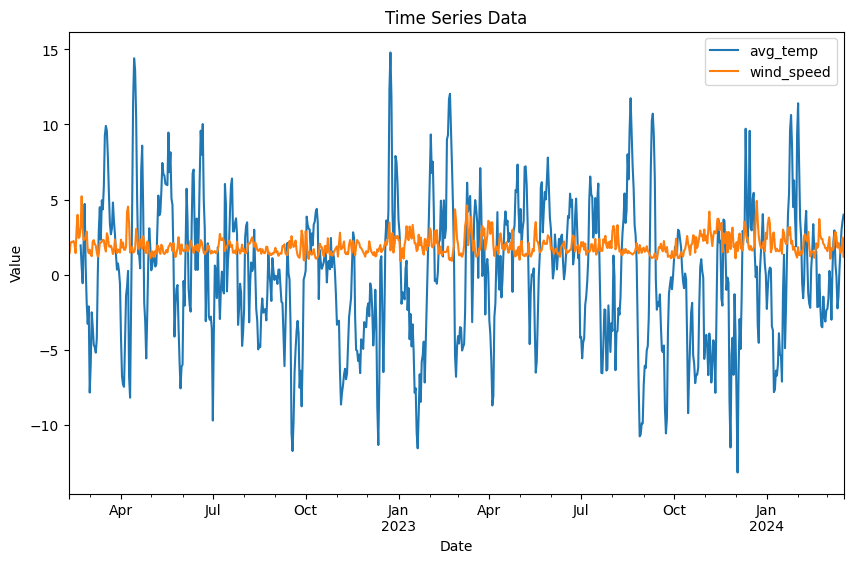

In [21]:
dates = weather_data.index

# Plot the time series
plt.figure(figsize=(10, 6))
weather_data_temp_deseasonalized.plot()
weather_data_wind.plot()
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

### Next Steps:
1.) Compute ACF and PACF and significant lags for wind_speed<br>
2.) Compute ACF and PACF and significant lags for avg_temp<br>
3.) Create Training- and Test-Dataset for wind_speed<br>
4.) Create Training- and Test-Dataset for avg_temp

In [22]:
def get_significant_acf_and_pacf_lags(data):
    """Calculate the number of significant lags in the ACF and PACF"""
    acf = statsmodels.tsa.stattools.acf(data, nlags=40)
    pacf = statsmodels.tsa.stattools.pacf(data, nlags=40)
    significant_acf_lags = len([lag for lag, acf_value in enumerate(acf) if abs(acf_value) > 0.2])-1
    significant_pacf_lags = len([lag for lag, pacf_value in enumerate(pacf) if abs(pacf_value) > 0.2])-1
    return significant_acf_lags, significant_pacf_lags

In [23]:
def create_train_and_test_data(data, test_size=0.2):
    """Create a non-random Training- and a Test-Dataset"""
    train_data = data.iloc[:-int(len(data) * test_size)]
    test_data = data.iloc[-int(len(data) * test_size):]    
    return train_data, test_data

In [24]:
def plot_acf_and_pacf(data):
    acf_data = acf(data, nlags=40)
    pacf_data= pacf(data, nlags=40)
    
    # Create ACF plot
    plt.figure(figsize=(12, 6))
    plot_acf(data, lags=40, alpha=1)  # Plot ACF using statsmodels
    plt.fill_between(range(len(acf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.show()
    
    # Create PACF plot
    plt.figure(figsize=(12, 6))
    plot_pacf(data, lags=40, alpha=1)  # Plot PACF using statsmodels
    plt.fill_between(range(len(pacf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.show()

## Create Model

### Next Steps:
1.) Create Model<br>
2.) Check if Coefficients are significant<br>
3.) Compute the Accuray of the Model<br>
4.) Check if there is a better Model

In [25]:
def ARIMA_model(data, p, d, q):
    """Model the data with an ARIMA-Model; if there is seasonality, a seasonal difference is calculated
    Some warnings are ignored, since many parameters are tested for the best model"""
    warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
    warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
    warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")    

    model = statsmodels.tsa.arima.model.ARIMA(data, order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model

In [26]:
def check_significance_of_coefficients(fitted_model, significance_level=0.5) -> bool:
    """Check, if the computed coefficients are significant"""
    p_values = fitted_model.pvalues
    for i, p_value in enumerate(p_values):
        if not (abs(p_value) < significance_level):
            return False
        return True

In [27]:
def check_accuracy(fitted_model, test_data):
    """Check, how accurate the fitted Model used on the test-dataset,
    by computing the MeanSquaredError and the RootMeanSquaredError"""
    y_true = test_data
    y_pred = fitted_model.forecast(steps=len(test_data))
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

In [33]:
def find_best_model(train_data, test_data, acf_lag, pacf_lag) -> dict:
    """Try different Meta-Parameters to check, if the AIC and MSE are becoming better, return the best model"""
    best_model = dict(
        p = 0,
        d = 0,
        q = 0,
        fitted_model = None,
        mse = 0,
        rmse = 0
    )
    
    lowest_aic = 10000
    lowest_mse = 10000
    
    for p in range(acf_lag-2 if acf_lag>2 else 0, acf_lag+2):
        for q in range(pacf_lag-2 if pacf_lag>2 else 0, pacf_lag+2):
            for d in range(2):
                print(f'ARIMA({p}, {d}, {q})')
                fitted_model = ARIMA_model(train_data, p, d, q)
                if not check_significance_of_coefficients(fitted_model):
                    continue
                mse, rmse = check_accuracy(fitted_model, test_data)
                if fitted_model.aic<lowest_aic and mse<lowest_mse:
                    lowest_aic=fitted_model.aic
                    lowest_mse=mse
                    best_model['p'] = p
                    best_model['d'] = d
                    best_model['q'] = q
                    best_model['fitted_model']= fitted_model
                    best_model['mse'] = mse
                    best_model['rmse'] = rmse

    return best_model

In [34]:
def print_model_information(best_model):
    """Generate Print-Statement with the most important information about the best Model"""
    print(f'{best_model["p"]}, {best_model["d"]}, {best_model["q"]}:\n{best_model["fitted_model"].summary()} \nMSE: {best_model["mse"]}\n')

In [35]:
def run_modelling_process(data):
    """Create Training- and Test-Dataset, fit the model and check the accuracy"""
    acf_lag, pacf_lag = get_significant_acf_and_pacf_lags(data)
    train_data, test_data = create_train_and_test_data(data)
    best_model = find_best_model(train_data, test_data, acf_lag, pacf_lag)
    
    print_model_information(best_model)
    return best_model

In [36]:
best_model_wind = run_modelling_process(weather_data_wind)

ARIMA(1, 0, 0)
ARIMA(1, 1, 0)
ARIMA(1, 0, 1)
ARIMA(1, 1, 1)
ARIMA(1, 0, 2)
ARIMA(1, 1, 2)
ARIMA(2, 0, 0)
ARIMA(2, 1, 0)
ARIMA(2, 0, 1)
ARIMA(2, 1, 1)
ARIMA(2, 0, 2)
ARIMA(2, 1, 2)
ARIMA(3, 0, 0)
ARIMA(3, 1, 0)
ARIMA(3, 0, 1)
ARIMA(3, 1, 1)
ARIMA(3, 0, 2)
ARIMA(3, 1, 2)
ARIMA(4, 0, 0)
ARIMA(4, 1, 0)
ARIMA(4, 0, 1)
ARIMA(4, 1, 1)
ARIMA(4, 0, 2)
ARIMA(4, 1, 2)
1, 0, 2:
                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                  616
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -415.295
Date:                Tue, 19 Mar 2024   AIC                            840.589
Time:                        08:05:25   BIC                            862.706
Sample:                    02-08-2022   HQIC                           849.189
                         - 10-16-2023                                         
Covariance Type:                  opg                                         

In [37]:
best_model_temp = run_modelling_process(weather_data_temp_deseasonalized)

ARIMA(9, 0, 3)
ARIMA(9, 1, 3)
ARIMA(9, 0, 4)
ARIMA(9, 1, 4)
ARIMA(9, 0, 5)
ARIMA(9, 1, 5)
ARIMA(9, 0, 6)
ARIMA(9, 1, 6)
ARIMA(10, 0, 3)
ARIMA(10, 1, 3)
ARIMA(10, 0, 4)
ARIMA(10, 1, 4)
ARIMA(10, 0, 5)
ARIMA(10, 1, 5)
ARIMA(10, 0, 6)
ARIMA(10, 1, 6)
ARIMA(11, 0, 3)
ARIMA(11, 1, 3)
ARIMA(11, 0, 4)
ARIMA(11, 1, 4)
ARIMA(11, 0, 5)
ARIMA(11, 1, 5)
ARIMA(11, 0, 6)
ARIMA(11, 1, 6)
ARIMA(12, 0, 3)
ARIMA(12, 1, 3)
ARIMA(12, 0, 4)
ARIMA(12, 1, 4)
ARIMA(12, 0, 5)
ARIMA(12, 1, 5)
ARIMA(12, 0, 6)
ARIMA(12, 1, 6)
10, 1, 6:
                               SARIMAX Results                                
Dep. Variable:               avg_temp   No. Observations:                  606
Model:                ARIMA(10, 1, 6)   Log Likelihood               -1302.422
Date:                Tue, 19 Mar 2024   AIC                           2638.843
Time:                        08:06:24   BIC                           2713.732
Sample:                    02-20-2022   HQIC                          2667.985
            

## Forecasting

In [85]:
def forecasting(weather_data, best_model_wind, best_model_temp, forecast_horizon=50):

    weather_data_temp = weather_data.avg_temp
    weather_data_wind = weather_data.wind_speed
    weather_data_temp_deseasonalized = weather_data_temp.diff(12).dropna()
    
    forecasting_model_wind = ARIMA_model(weather_data_wind, best_model_wind['p'], best_model_wind['d'], best_model_wind['q'])
    forecasting_model_temp = ARIMA_model(weather_data_temp_deseasonalized, best_model_temp['p'], best_model_temp['d'], best_model_temp['q'])
    
    index_future = pd.date_range(start=weather_data.index[-1], periods=forecast_horizon + 1, freq='D')[1:]
    forecast_df = pd.DataFrame(index=index_future, columns=['Wind', 'Temperature'])
    wind_forecast = forecasting_model_wind.get_forecast(steps=forecast_horizon)  # 95% confidence interval
    temp_forecast = forecasting_model_temp.get_forecast(steps=forecast_horizon)  # 95% confidence interval
    
    # Add back the seasonal component to the deseasonalized temperature forecast
    wind_mean = wind_forecast.summary_frame()['mean']
    temp_mean = temp_forecast.summary_frame()['mean']
    wind_lower = wind_forecast.summary_frame().mean_ci_lower
    wind_upper = wind_forecast.summary_frame().mean_ci_upper
    temp_lower = temp_forecast.summary_frame().mean_ci_lower
    temp_upper = temp_forecast.summary_frame().mean_ci_upper
    
    forecast_df['Wind'] = wind_mean
    forecast_df['Wind_Lower_CI'] = wind_lower
    forecast_df['Wind_Upper_CI'] = wind_upper
    forecast_df['Temperature'] = temp_mean.cumsum()  # re-seasonalized
    forecast_df['Temperature_CI_Difference'] = temp_upper - temp_lower
    forecast_df['Temperature_Lower_CI'] = forecast_df['Temperature'] - forecast_df['Temperature_CI_Difference']
    forecast_df['Temperature_Upper_CI'] = forecast_df['Temperature'] + forecast_df['Temperature_CI_Difference']

    return forecast_df

In [86]:
def plot_forecasting(forecast_df, weather_data):

    # Plot the observed data
    plt.figure(figsize=(10, 6))
    plt.plot(weather_data.index, weather_data['avg_temp'], label='Observed Temperature', color='blue')
    plt.plot(weather_data.index, weather_data['wind_speed'], label='Observed Wind', color='green')
    
    # Plot the forecasted values
    plt.plot(forecast_df.index, forecast_df['Temperature'], label='Forecasted Temperature', color='red')
    plt.plot(forecast_df.index, forecast_df['Wind'], label='Forecasted Wind', color='green')
    
    # Add shades for uncertainty intervals
    plt.fill_between(forecast_df.index, forecast_df['Temperature_Lower_CI'], forecast_df['Temperature_Upper_CI'], color='lightcoral', alpha=0.3)
    plt.fill_between(forecast_df.index, forecast_df['Wind_Lower_CI'], forecast_df['Wind_Upper_CI'], color='lightgreen', alpha=0.3)
    
    # Add labels, legend, and title
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Observed and Forecasted Data with Confidence Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

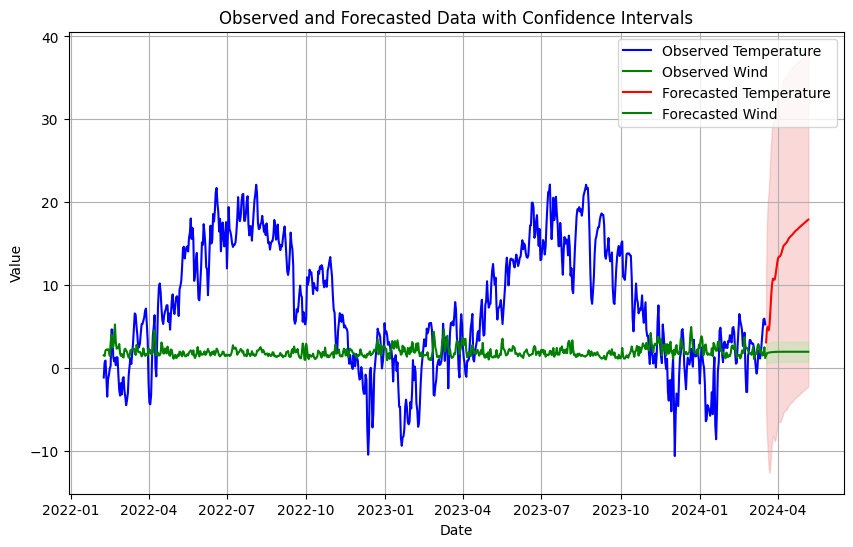

In [87]:
df = forecasting(weather_data, best_model_wind, best_model_temp)
plot_forecasting(df, weather_data)

In [39]:
# Make predictions
predictions = model_fit.predict(start=len(detrended_data), end=len(detrended_data) + 10)

# Plot original data, detrended data, and predictions
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data, label='Original Data')
plt.title('Original Data')
plt.subplot(2, 1, 2)
plt.plot(detrended_data, label='Detrended Data', color='orange')
plt.plot(predictions, label='Predictions', linestyle='--', color='green')
plt.title('Detrended Data and Predictions')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'model_fit' is not defined

In [40]:
weather_data

,avg_temp,rain,wind_speed,clouds
2022-05-09 00:00:00+00:00,10.468866,0.028264,1.542406,49.792824
2022-05-10 00:00:00+00:00,12.242014,0.000671,1.386188,21.692130
2022-05-11 00:00:00+00:00,14.441782,0.004954,1.997621,27.585648
2022-05-12 00:00:00+00:00,14.614468,0.026667,1.877090,33.341435
2022-05-13 00:00:00+00:00,13.198264,0.094225,1.448206,68.994213
...,...,...,...,...
2024-03-13 00:00:00+00:00,3.375845,0.531401,1.735776,79.964976
2024-03-14 00:00:00+00:00,4.733213,0.000978,1.460917,37.650966
2024-03-15 00:00:00+00:00,5.849306,0.318750,1.725823,73.130787
2024-03-16 00:00:00+00:00,5.925347,0.204931,2.470711,71.378472
